In [100]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
%reload_ext autoreload
%autoreload 1
%aimport utils

# og_data = pd.read_csv('data.csv')
og_data = pd.read_csv('data_engineered.csv', parse_dates=['game_date'])


In [101]:
#feature engineering

#data parsing
og_data.seconds_remaining = pd.to_timedelta(og_data.seconds_remaining, unit='s')
og_data.minutes_remaining = pd.to_timedelta(og_data.minutes_remaining, unit='m')
og_data['time_remaining'] = og_data.minutes_remaining+og_data.seconds_remaining

#binning of time_remaining
time_remaining_bins_labels = [[
    pd.Timedelta(minutes = 0),
    pd.Timedelta(minutes = 5),
    pd.Timedelta(minutes = 10),
    pd.Timedelta(minutes = 20)
], ['0-5min', '5-10min', '10-20min']]

og_data['time_remaining_label'] = pd.cut(og_data['time_remaining'], time_remaining_bins_labels[0], labels = time_remaining_bins_labels[1])
og_data['time_remaining_label2']=og_data['time_remaining_label'].astype('category').cat.codes

#use only if data needs to be regenerated
# utils.engineer_features_and_write_file(og_data)

#there are 5000 shot_made_flag null values, that's our test data, the rest is training data
test = og_data.loc[og_data['shot_made_flag'].isnull()]
data = og_data.loc[og_data['shot_made_flag'].notnull()]

og_data.describe()

game_event_id       game_id           lat         loc_x         loc_y  \
count   30697.000000  3.069700e+04  30697.000000  30697.000000  30697.000000   
mean      249.190800  2.476407e+07     33.953192      7.110499     91.107535   
std       150.003712  7.755175e+06      0.087791    110.124578     87.791361   
min         2.000000  2.000001e+07     33.253300   -250.000000    -44.000000   
25%       110.000000  2.050008e+07     33.884300    -68.000000      4.000000   
50%       253.000000  2.090035e+07     33.970300      0.000000     74.000000   
75%       368.000000  2.960047e+07     34.040300     95.000000    160.000000   
max       659.000000  4.990009e+07     34.088300    248.000000    791.000000   

                lon          minutes_remaining        period      playoffs  \
count  30697.000000                      30697  30697.000000  30697.000000   
mean    -118.262690  0 days 00:04:53.137440140      2.519432      0.146562   
std        0.110125  0 days 00:03:26.993848667      1.153665      0.353674   
min     -118.519800            0 days 00:00:00      1.000000      0.000000   
25%     -118.337800            0 days 00:02:00      1.000000      0.000000   
50%     -118.269800            0 days 00:05:00      3.000000      0.000000   
75%     -118.174800            0 days 00:08:00      3.000000      0.000000   
max     -118.021800            0 days 00:11:00      7.000000      1.000000   

               seconds_remaining  ...       team_id       shot_id  \
count                      30697  ...  3.069700e+04  30697.000000   
mean   0 days 00:00:28.365084535  ...  1.610613e+09  15349.000000   
std    0 days 00:00:17.478949230  ...  0.000000e+00   8861.604943   
min              0 days 00:00:00  ...  1.610613e+09      1.000000   
25%              0 days 00:00:13  ...  1.610613e+09   7675.000000   
50%              0 days 00:00:28  ...  1.610613e+09  15349.000000   
75%              0 days 00:00:43  ...  1.610613e+09  23023.000000   
max              0 days 00:00:59  ...  1.610613e+09  30697.000000   

         efficiency  efficiency_normalized     home_game  shot_zone_area2  \
count  30697.000000           30697.000000  30697.000000     30697.000000   
mean       3.360068               0.108389      0.487214         2.438023   
std        4.248270               0.137041      0.499845         1.532001   
min        0.000000               0.000000      0.000000         0.000000   
25%        0.000000               0.000000      0.000000         1.000000   
50%        2.000000               0.064516      0.000000         2.000000   
75%        5.000000               0.161290      1.000000         4.000000   
max       31.000000               1.000000      1.000000         5.000000   

              angle      distance             time_remaining  \
count  25515.000000  30697.000000                      30697   
mean       4.028277    138.476605  0 days 00:05:21.502524676   
std       52.244455     94.919782  0 days 00:03:28.175175675   
min      -90.000000      0.000000            0 days 00:00:00   
25%      -44.395313     53.338541            0 days 00:02:22   
50%        3.301866    154.350251            0 days 00:05:04   
75%       50.931527    211.243935            0 days 00:08:18   
max       90.000000    791.818792            0 days 00:11:54   

       time_remaining_label2  
count           30697.000000  
mean                0.617161  
std                 0.726174  
min                -1.000000  
25%                 0.000000  
50%                 1.000000  
75%                 1.000000  
max                 2.000000  

[8 rows x 22 columns]

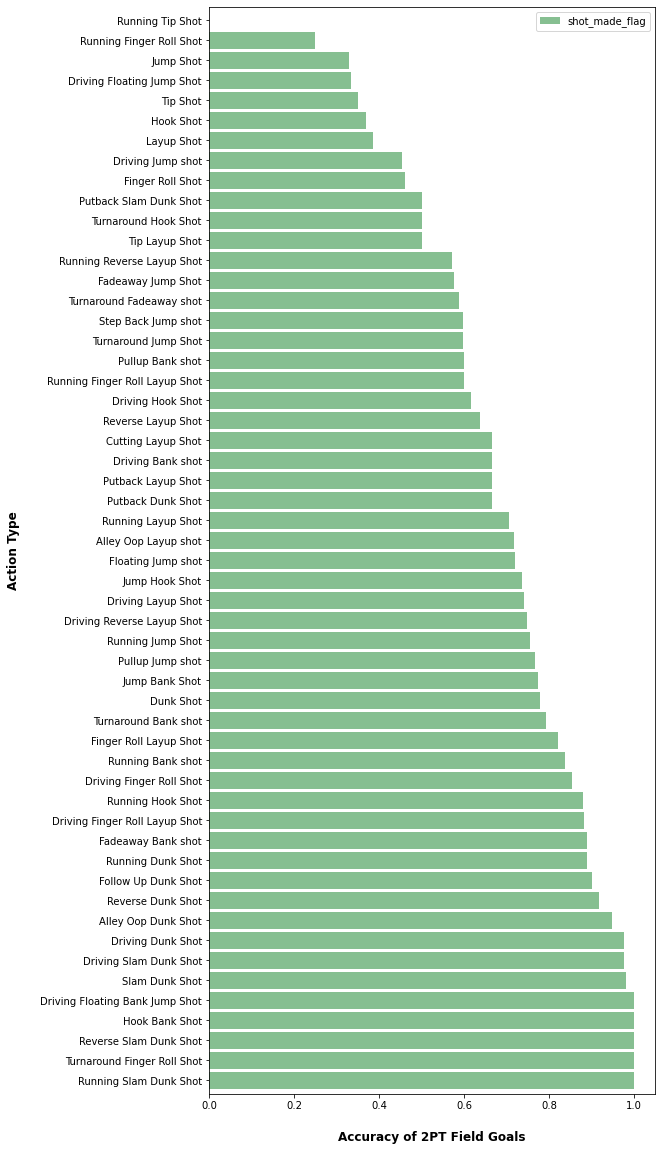

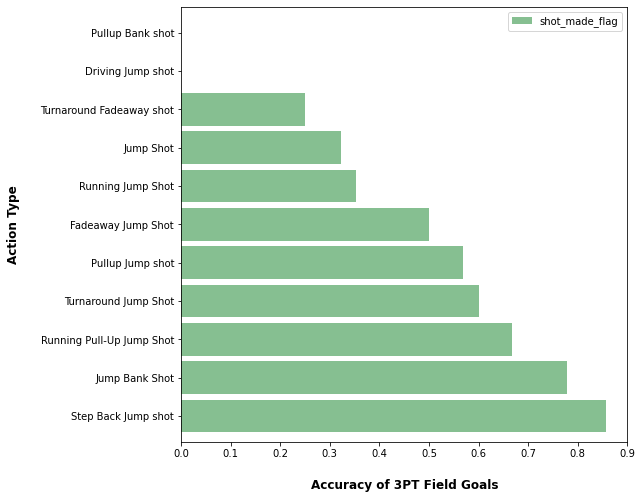

In [102]:
#action type accuracy
groups = data[['action_type','shot_type','shot_made_flag']].groupby(['action_type','shot_type'], as_index=False).mean()

parameters = {
    '2PT Field Goal': {
        'figsize': {
            'y': 20
        }
    },
    '3PT Field Goal': {
        'figsize': {
            'y': 8
        }
    }
}

#this plot might get merged into a single one
for n, g in groups.groupby('shot_type'):
    ax = g.sort_values(by='shot_made_flag', ascending=False).plot(kind='barh', x='action_type', y='shot_made_flag', figsize=(8, parameters[n]['figsize']['y']), color='#86bf91', zorder=2, width=0.85)
    # Set x-axis label
    ax.set_xlabel('Accuracy of ' + n + 's', labelpad=20, weight='bold', size=12)
    # Set y-axis label
    ax.set_ylabel('Action Type', labelpad=20, weight='bold', size=12);

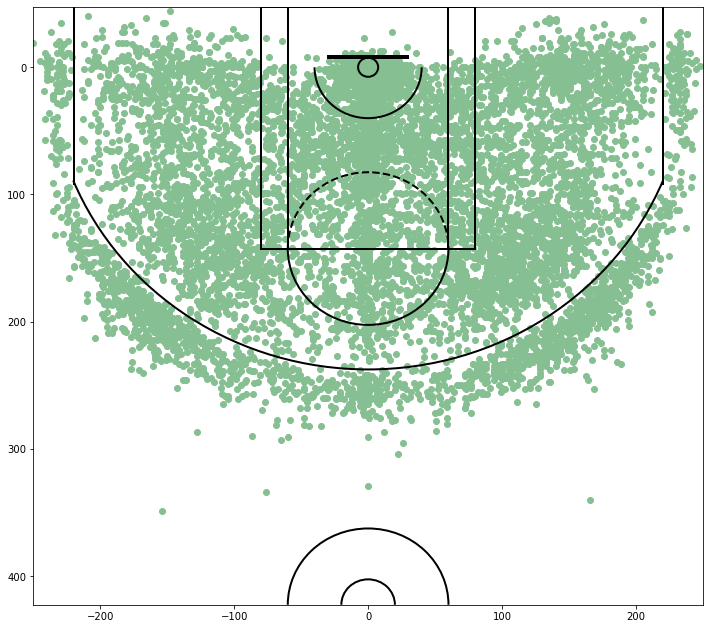

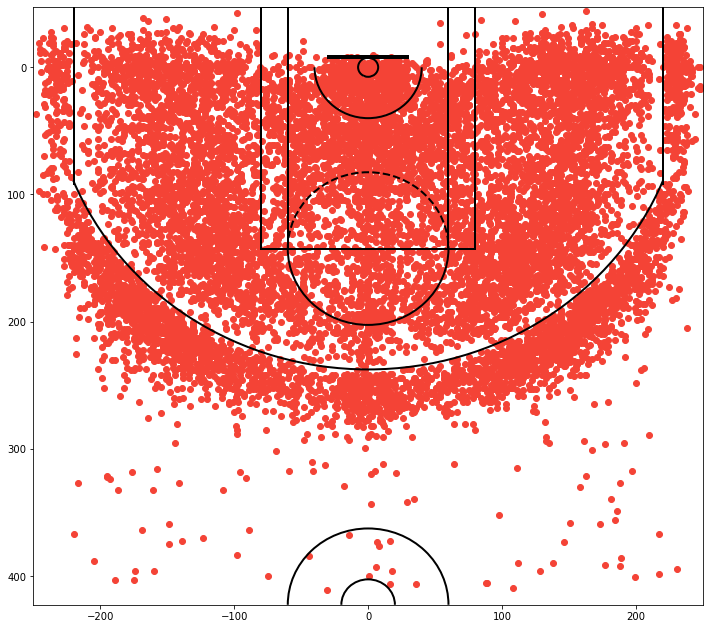

In [103]:
#shots made vs shots failed
parameters = [{
    'shot_made_flag': 1,
    'color': '#86bf91'
}, {
    'shot_made_flag': 0,
    'color': '#f44336'
}]

for x in range(2):
    plt.figure(figsize=(12,11))
    shots_made = data.loc[data['shot_made_flag'] == parameters[x]['shot_made_flag']]
    plt.scatter(shots_made.loc_x, shots_made.loc_y, color=parameters[x]['color'])

    utils.draw_court()
    # Adjust plot limits to just fit in half court
    plt.xlim(-250,250)
    # Descending values along th y axis from bottom to top
    # in order to place the hoop by the top of plot
    plt.ylim(422.5, -47.5)
    # get rid of axis tick labels
    # plt.tick_params(labelbottom=False, labelleft=False)
    plt.show();

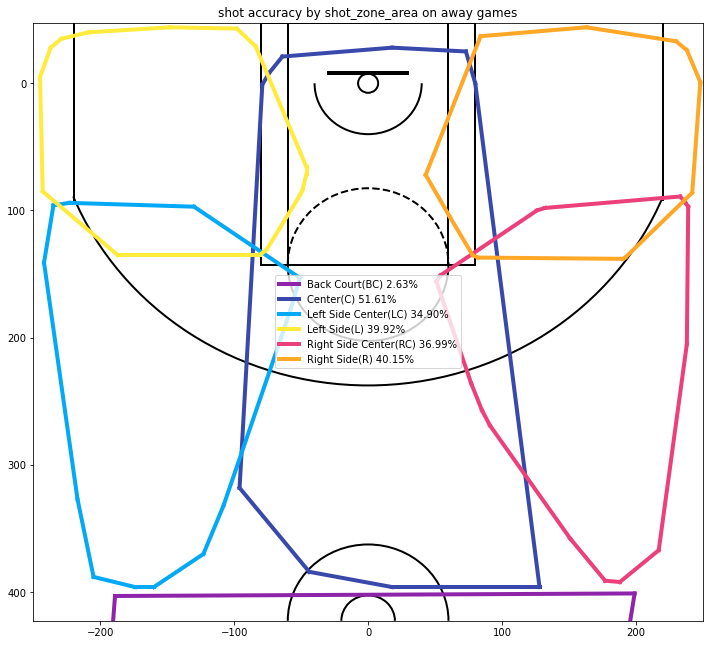

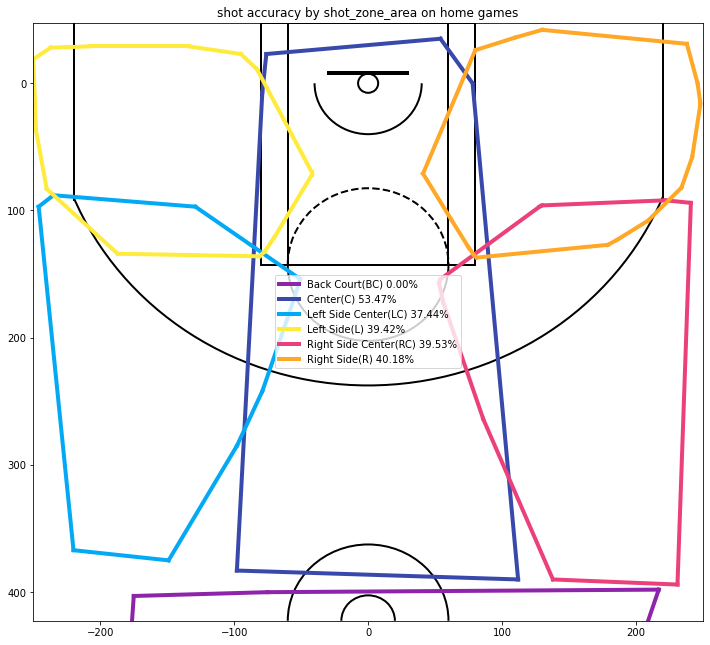

In [104]:
#shot accuracy by home or away games
from scipy.spatial import ConvexHull, convex_hull_plot_2d; from matplotlib.lines import Line2D;

colors = {
    'Back Court(BC)': '#8e24aa', #purple
    'Center(C)': '#3949ab', #indigo
    'Left Side Center(LC)': '#03a9f4', #light blue
    'Left Side(L)': '#ffeb3b', #yellow
    'Right Side Center(RC)': '#ec407a', #pink
    'Right Side(R)': '#ffa726' #orange
}

home_or_away_str = ['away', 'home']

for n, g in data.groupby(['home_game'], as_index=False):
    sub_data = g[['shot_zone_area', 'loc_x','loc_y', 'shot_made_flag']]
    hulls = []
    legends = []
    for n2, g2 in sub_data.groupby('shot_zone_area', as_index=False):
        points = g2[['loc_x','loc_y']].to_numpy()
        hulls.append({ 
            'name': n2, 
            'points': points,
            'hull': None if points.size < 3 else ConvexHull(points)
        })
        legends.append(Line2D([0], [0], color=colors[n2], lw=4, label=n2 + ' ' + '{:.2%}'.format(g2['shot_made_flag'].mean())))
    plt.figure(figsize=(12,11))
    ax = utils.draw_court()
    for hull in hulls:
        # plt.text(hull['centroid'][0], hull['centroid'][1], hull['accuracy'], fontsize=12)
        if hull['hull'] is not None:
            for simplex in hull['hull'].simplices:
                plt.plot(hull['points'][simplex, 0], hull['points'][simplex, 1], 'k-', color=colors[hull['name']], linewidth=4)

    ax.legend(handles=legends, loc='center')

    plt.xlim(-250,250)
    # # Descending values along th y axis from bottom to top
    # # in order to place the hoop by the top of plot
    plt.ylim(422.5, -47.5)
    # # get rid of axis tick labels
    # # plt.tick_params(labelbottom=False, labelleft=False)
    plt.title('shot accuracy by shot_zone_area on ' + home_or_away_str[n] + ' games')
    plt.show();

In [105]:
## Perform DBSCAN clustering
X = data[['loc_x', 'loc_y']]
X = StandardScaler().fit_transform(X)
db = DBSCAN(eps=0.07, min_samples=50).fit(X)

In [106]:
labels = db.labels_
data["cluster"] = labels

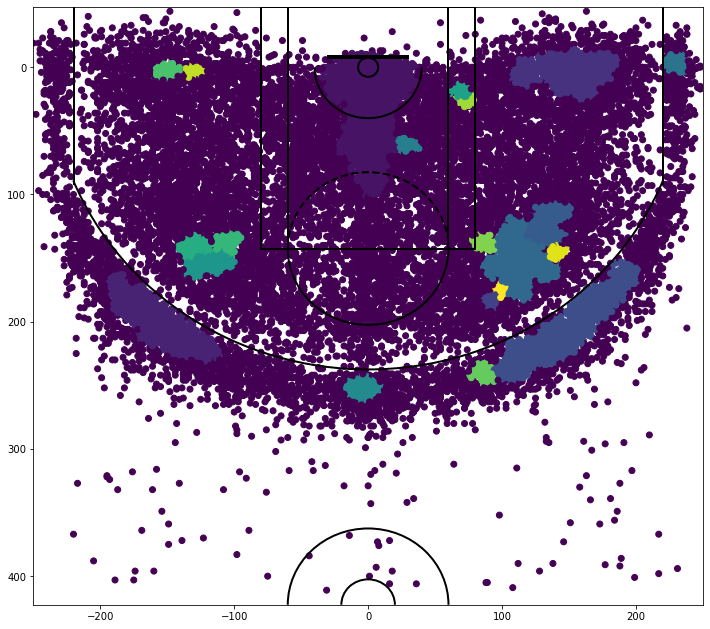

In [107]:
plt.figure(figsize=(12,11))
# plt.scatter(data.loc_x, data.loc_y, c=np.where((data['shot_made_flag'] == 1), 'g', 'r'))
plt.scatter(data.loc_x, data.loc_y, c=data.cluster)
utils.draw_court()
# Adjust plot limits to just fit in half court
plt.xlim(-250,250)
# Descending values along th y axis from bottom to top
# in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)
# get rid of axis tick labels
# plt.tick_params(labelbottom=False, labelleft=False)
plt.show();

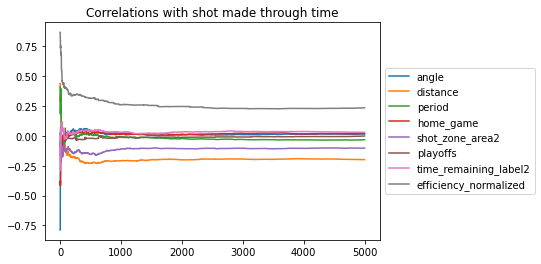

In [112]:
#use in case correlations need to be regenerated
# utils.generate_correlations(data, test)

correlations = pd.read_csv('shot_made_correlations.csv')[['angle', 'distance', 'period', 'home_game', 'shot_zone_area2', 'playoffs', 'time_remaining_label2', 'efficiency_normalized']].plot.line()

plt.title('Correlations with shot made through time', color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

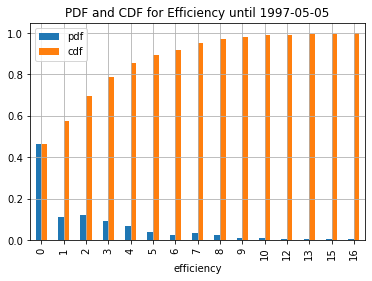

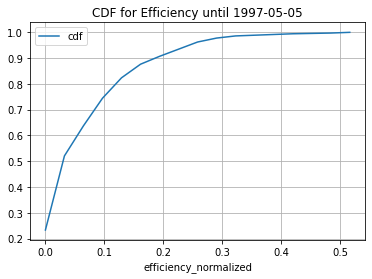

In [109]:
utils.draw_efficiency_pdf_cdf_until_date(data, test, '05/05/1997')
